<a href="https://colab.research.google.com/github/Yasushi400/ISD/blob/main/kanadaset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 使用ライブラリ

In [3]:
!pip install japanize_matplotlib
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 60.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=2dbff2c2c2f4f5711b25a616c259a06ba7769c85cde6e9c1bb94d7b521f1e194
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 10.0 MB/s eta 0:00:00


In [4]:
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from skopt import BayesSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# データ整理

In [27]:
df = pd.read_csv("https://raw.githubusercontent.com/Yasushi400/kanadataset/main/kana_dataset/data/20211_20224.csv",encoding="cp932")

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39224 entries, 0 to 39223
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   No          39224 non-null  int64  
 1   種類          39224 non-null  object 
 2   地域          24737 non-null  object 
 3   市区町村コード     39224 non-null  int64  
 4   都道府県名       39224 non-null  object 
 5   市区町村名       39224 non-null  object 
 6   地区名         39223 non-null  object 
 7   最寄駅：名称      38868 non-null  object 
 8   最寄駅：距離（分）   38864 non-null  object 
 9   取引価格（総額）    39224 non-null  int64  
 10  坪単価         8182 non-null   float64
 11  間取り         13643 non-null  object 
 12  面積（㎡）       39224 non-null  object 
 13  取引価格（㎡単価）   8182 non-null   float64
 14  土地の形状       24736 non-null  object 
 15  間口          22427 non-null  object 
 16  延床面積（㎡）     16075 non-null  object 
 17  建築年         29679 non-null  object 
 18  建物の構造       28112 non-null  object 
 19  用途          25612 non-nul

In [29]:
# ラベルエンコーディングを行い、分析対象外データを除外
df["種類(Encoding)"] = LabelEncoder().fit_transform(df["種類"].values) + 1
df = df[df["種類"] != "林地"]
df = df[df["種類"] != "農地"]
df = df[df["種類"] != "宅地(土地)"]
"""
df_forest =df[df["種類"] == "林地"]
df_arg = df[df["種類"] == "農地"]
df_land = df[df["種類"] == "宅地(土地)"]
"""

# 分析対象外データを除外
df = df[df["地域"] != "商業地"]
df = df[df["地域"] != "工業地"]
df = df[df["地域"] != "宅地見込地"]
df = df[df["今後の利用目的"] == "住宅"]

#不必要なコラムを除外
df = df.drop(["地域","都道府県名","坪単価","取引価格（㎡単価）",
              "今後の利用目的","用途","取引の事情等"],axis="columns")

# ラベルエンコーディングを行う
df["最寄駅：名称(Encoding)"] = LabelEncoder().fit_transform(df["最寄駅：名称"].values) + 1

# ラベルエンコーディングを行う
df = df.fillna({"地区名":"None"})
df = df[df["地区名"] != "None"]
df["地区名(Encoding)"] = LabelEncoder().fit_transform(df["地区名"].values) + 1

# 欠損値を埋め、ラベルエンコーディングを行う
df = df.fillna({"都市計画":"None"})
df = df.replace({"None":"都市計画区域外"})
df["都市計画(Encoding)"] = LabelEncoder().fit_transform(df["都市計画"].values) + 1

# 欠損データを除外し、かつ一部のデータを数値化
df = df.fillna({"最寄駅：距離（分）":"None"})
df = df[df["最寄駅：距離（分）"] != "None"]
df = df.replace({"30分?60分":45, "1H?1H30":75, "1H30?2H":105, "2H?": 120,})
df["最寄駅：距離（分）(Encoding)"] = df["最寄駅：距離（分）"].astype(int)

# 取引時間を数値化
df = df.replace({"2021年第１四半期":202101,"2021年第２四半期":202102,"2021年第３四半期":202103,"2021年第４四半期":202104,
                "2022年第１四半期":202201,"2022年第２四半期":202202,"2022年第３四半期":202203,"2022年第４四半期":202204})
df["取引時点(Encoding)"] = df["取引時点"].astype(int)

# 欠点があるデータを除外
df = df.fillna({"建物の構造":"None"})
df = df[df["建物の構造"] != "None"]

df = df.fillna({"建築年":"None"})
df = df[df["建築年"] != "None"]
df = df.replace({"戦前":"昭和20年"})
df["年号"] = df["建築年"].str[:2]
# "和暦"の 2文字目以降を取得し（df["和暦"].str[2:]）、
# "年"を除去（つまり""に置換）し（.str.replace("年","")）、
# int型に変換した値（.astype(int)）を"和暦_年"列として追加
df["和暦_年"] = df["建築年"].str[2:].str.replace("年","").astype(int)
# 年号ごとに西暦を算出し、"西暦_年"列として追加
df.loc[df["年号"] == "明治","西暦_年"] = df["和暦_年"] + 1867
df.loc[df["年号"] == "大正","西暦_年"] = df["和暦_年"] + 1911
df.loc[df["年号"] == "昭和","西暦_年"] = df["和暦_年"] + 1925
df.loc[df["年号"] == "平成","西暦_年"] = df["和暦_年"] + 1988
df.loc[df["年号"] == "令和","西暦_年"] = df["和暦_年"] + 2018
df["建築年(Encoding)"] = df["西暦_年"].astype(int)
df = df.drop(["年号","和暦_年","西暦_年"],axis="columns")

# 欠損値を"None"で埋める
# df = df.fillna("None")

df = df.reindex(columns=["No","種類","種類(Encoding)","市区町村名","市区町村コード",
                         "地区名","地区名(Encoding)","最寄駅：名称","最寄駅：名称(Encoding)",
                         "最寄駅：距離（分）","最寄駅：距離（分）(Encoding)",
                         "取引価格（総額）","間取り",
                         "面積（㎡）","土地の形状","間口","延床面積（㎡）","建築年(Encoding)","建物の構造",
                         "前面道路：方位","前面道路：種類","前面道路：幅員（ｍ）",
                         "都市計画","都市計画(Encoding)","取引時点","取引時点(Encoding)","改装"])

# 宅地(建物と土地)

In [30]:
df_oh = df[df["種類"] == "宅地(土地と建物)"]

#いらないコラムを除く
df_oh = df_oh.drop({"間取り","改装"},axis="columns")

#欠損データを除外
df_oh = df_oh.fillna({"間口":"None"})
df_oh = df_oh[df_oh["間口"] != "None"]
df_oh = df_oh[df_oh["間口"] != "50.0m以上"]

df_oh = df_oh.fillna({"延床面積（㎡）":"None"})
df_oh = df_oh[df_oh["延床面積（㎡）"] != "None"]

df_oh = df_oh.fillna({"前面道路：種類":"None"})
df_oh = df_oh[df_oh["前面道路：種類"] != "None"]

df_oh = df_oh.fillna({"前面道路：幅員（ｍ）":"None"})
df_oh = df_oh[df_oh["前面道路：幅員（ｍ）"] != "None"]

df_oh = df_oh[df_oh["面積（㎡）"] != "2000㎡以上"]

df_oh = df_oh[df_oh["延床面積（㎡）"] != "2000㎡以上"]


#エンコーディングを行う
df_oh["土地の形状(Encoding)"] = LabelEncoder().fit_transform(df_oh["土地の形状"].values) + 1

df_oh["建物の構造(Encoding)"] = LabelEncoder().fit_transform(df_oh["建物の構造"].values) + 1

df_oh["前面道路：方位(Encoding)"] = LabelEncoder().fit_transform(df_oh["前面道路：方位"].values) + 1

df_oh["前面道路：種類(Encoding)"] = LabelEncoder().fit_transform(df_oh["前面道路：種類"].values) + 1

#データ型の変換
df_oh["No"] = df_oh["No"].astype(int)

df_oh["市区町村(Encoding)"] = df_oh["市区町村コード"].astype(int)

df_oh["取引価格（総額）(Encoding)"] = df_oh["取引価格（総額）"].astype(int)

df_oh["面積（㎡）(Encoding)"] = df_oh["面積（㎡）"].astype(int)

df_oh["間口(Encoding)"] = df_oh["間口"].astype(float).astype(int)

df_oh["延床面積（㎡）(Encoding)"] = df_oh["延床面積（㎡）"].astype(int)

df_oh["前面道路：幅員（ｍ）(Encoding)"] = df_oh["前面道路：幅員（ｍ）"].astype(int)

#データを絞る
df_oh = df_oh[df_oh["取引価格（総額）(Encoding)"] < 90000000]


In [31]:
df_oh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11432 entries, 1 to 39219
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   No                    11432 non-null  int64 
 1   種類                    11432 non-null  object
 2   種類(Encoding)          11432 non-null  int64 
 3   市区町村名                 11432 non-null  object
 4   市区町村コード               11432 non-null  int64 
 5   地区名                   11432 non-null  object
 6   地区名(Encoding)         11432 non-null  int64 
 7   最寄駅：名称                11432 non-null  object
 8   最寄駅：名称(Encoding)      11432 non-null  int64 
 9   最寄駅：距離（分）             11432 non-null  object
 10  最寄駅：距離（分）(Encoding)   11432 non-null  int64 
 11  取引価格（総額）              11432 non-null  int64 
 12  面積（㎡）                 11432 non-null  object
 13  土地の形状                 11432 non-null  object
 14  間口                    11432 non-null  object
 15  延床面積（㎡）               11432 non-null

### 可視化

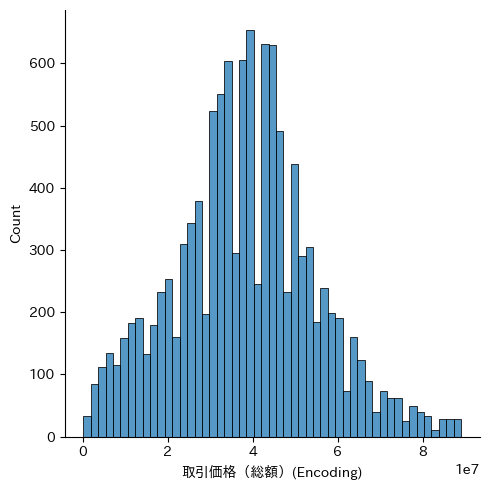

In [32]:
sns.displot(df_oh["取引価格（総額）(Encoding)"])

In [33]:
oh_sns = df_oh[["地区名(Encoding)","最寄駅：名称(Encoding)","最寄駅：距離（分）(Encoding)",
                "取引価格（総額）(Encoding)","面積（㎡）(Encoding)","土地の形状(Encoding)",
                "間口(Encoding)","延床面積（㎡）(Encoding)","建築年(Encoding)","建物の構造(Encoding)",
                "都市計画(Encoding)","取引時点(Encoding)"]]
oh_trans_sns = np.log(oh_sns).diff().dropna()

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


<Axes: xlabel='取引価格（総額）(Encoding)', ylabel='面積（㎡）(Encoding)'>

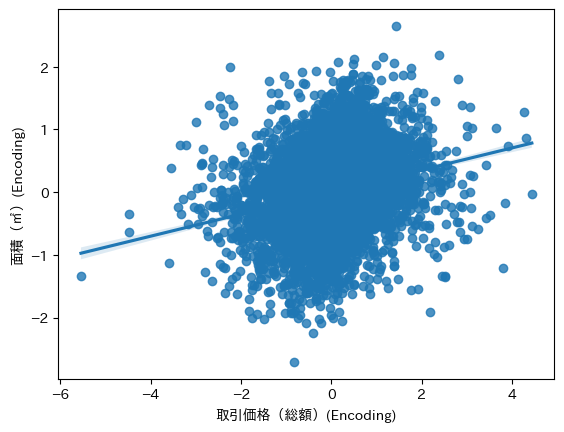

In [34]:
sns.regplot(x="取引価格（総額）(Encoding)",y="面積（㎡）(Encoding)",data=oh_trans_sns)

<Axes: xlabel='取引価格（総額）(Encoding)', ylabel='最寄駅：名称(Encoding)'>

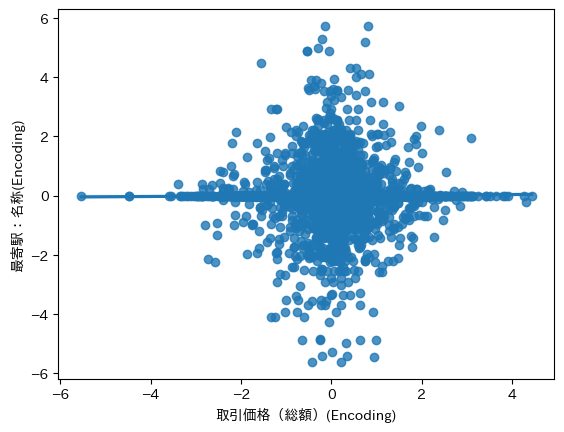

In [35]:
sns.regplot(x="取引価格（総額）(Encoding)",y="最寄駅：名称(Encoding)",data=oh_trans_sns)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


<Axes: xlabel='取引価格（総額）(Encoding)', ylabel='最寄駅：距離（分）(Encoding)'>

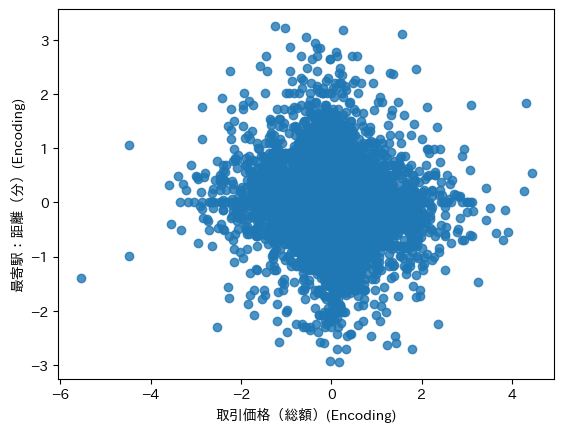

In [36]:
sns.regplot(x="取引価格（総額）(Encoding)",y="最寄駅：距離（分）(Encoding)",data=oh_trans_sns)

<Axes: xlabel='取引価格（総額）(Encoding)', ylabel='取引時点(Encoding)'>

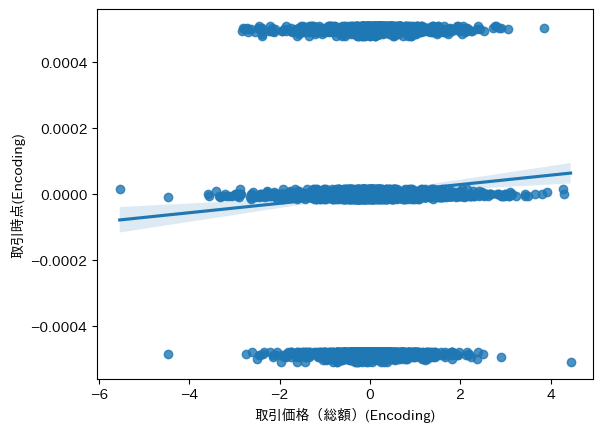

In [37]:
sns.regplot(x="取引価格（総額）(Encoding)",y="取引時点(Encoding)",data=oh_trans_sns)

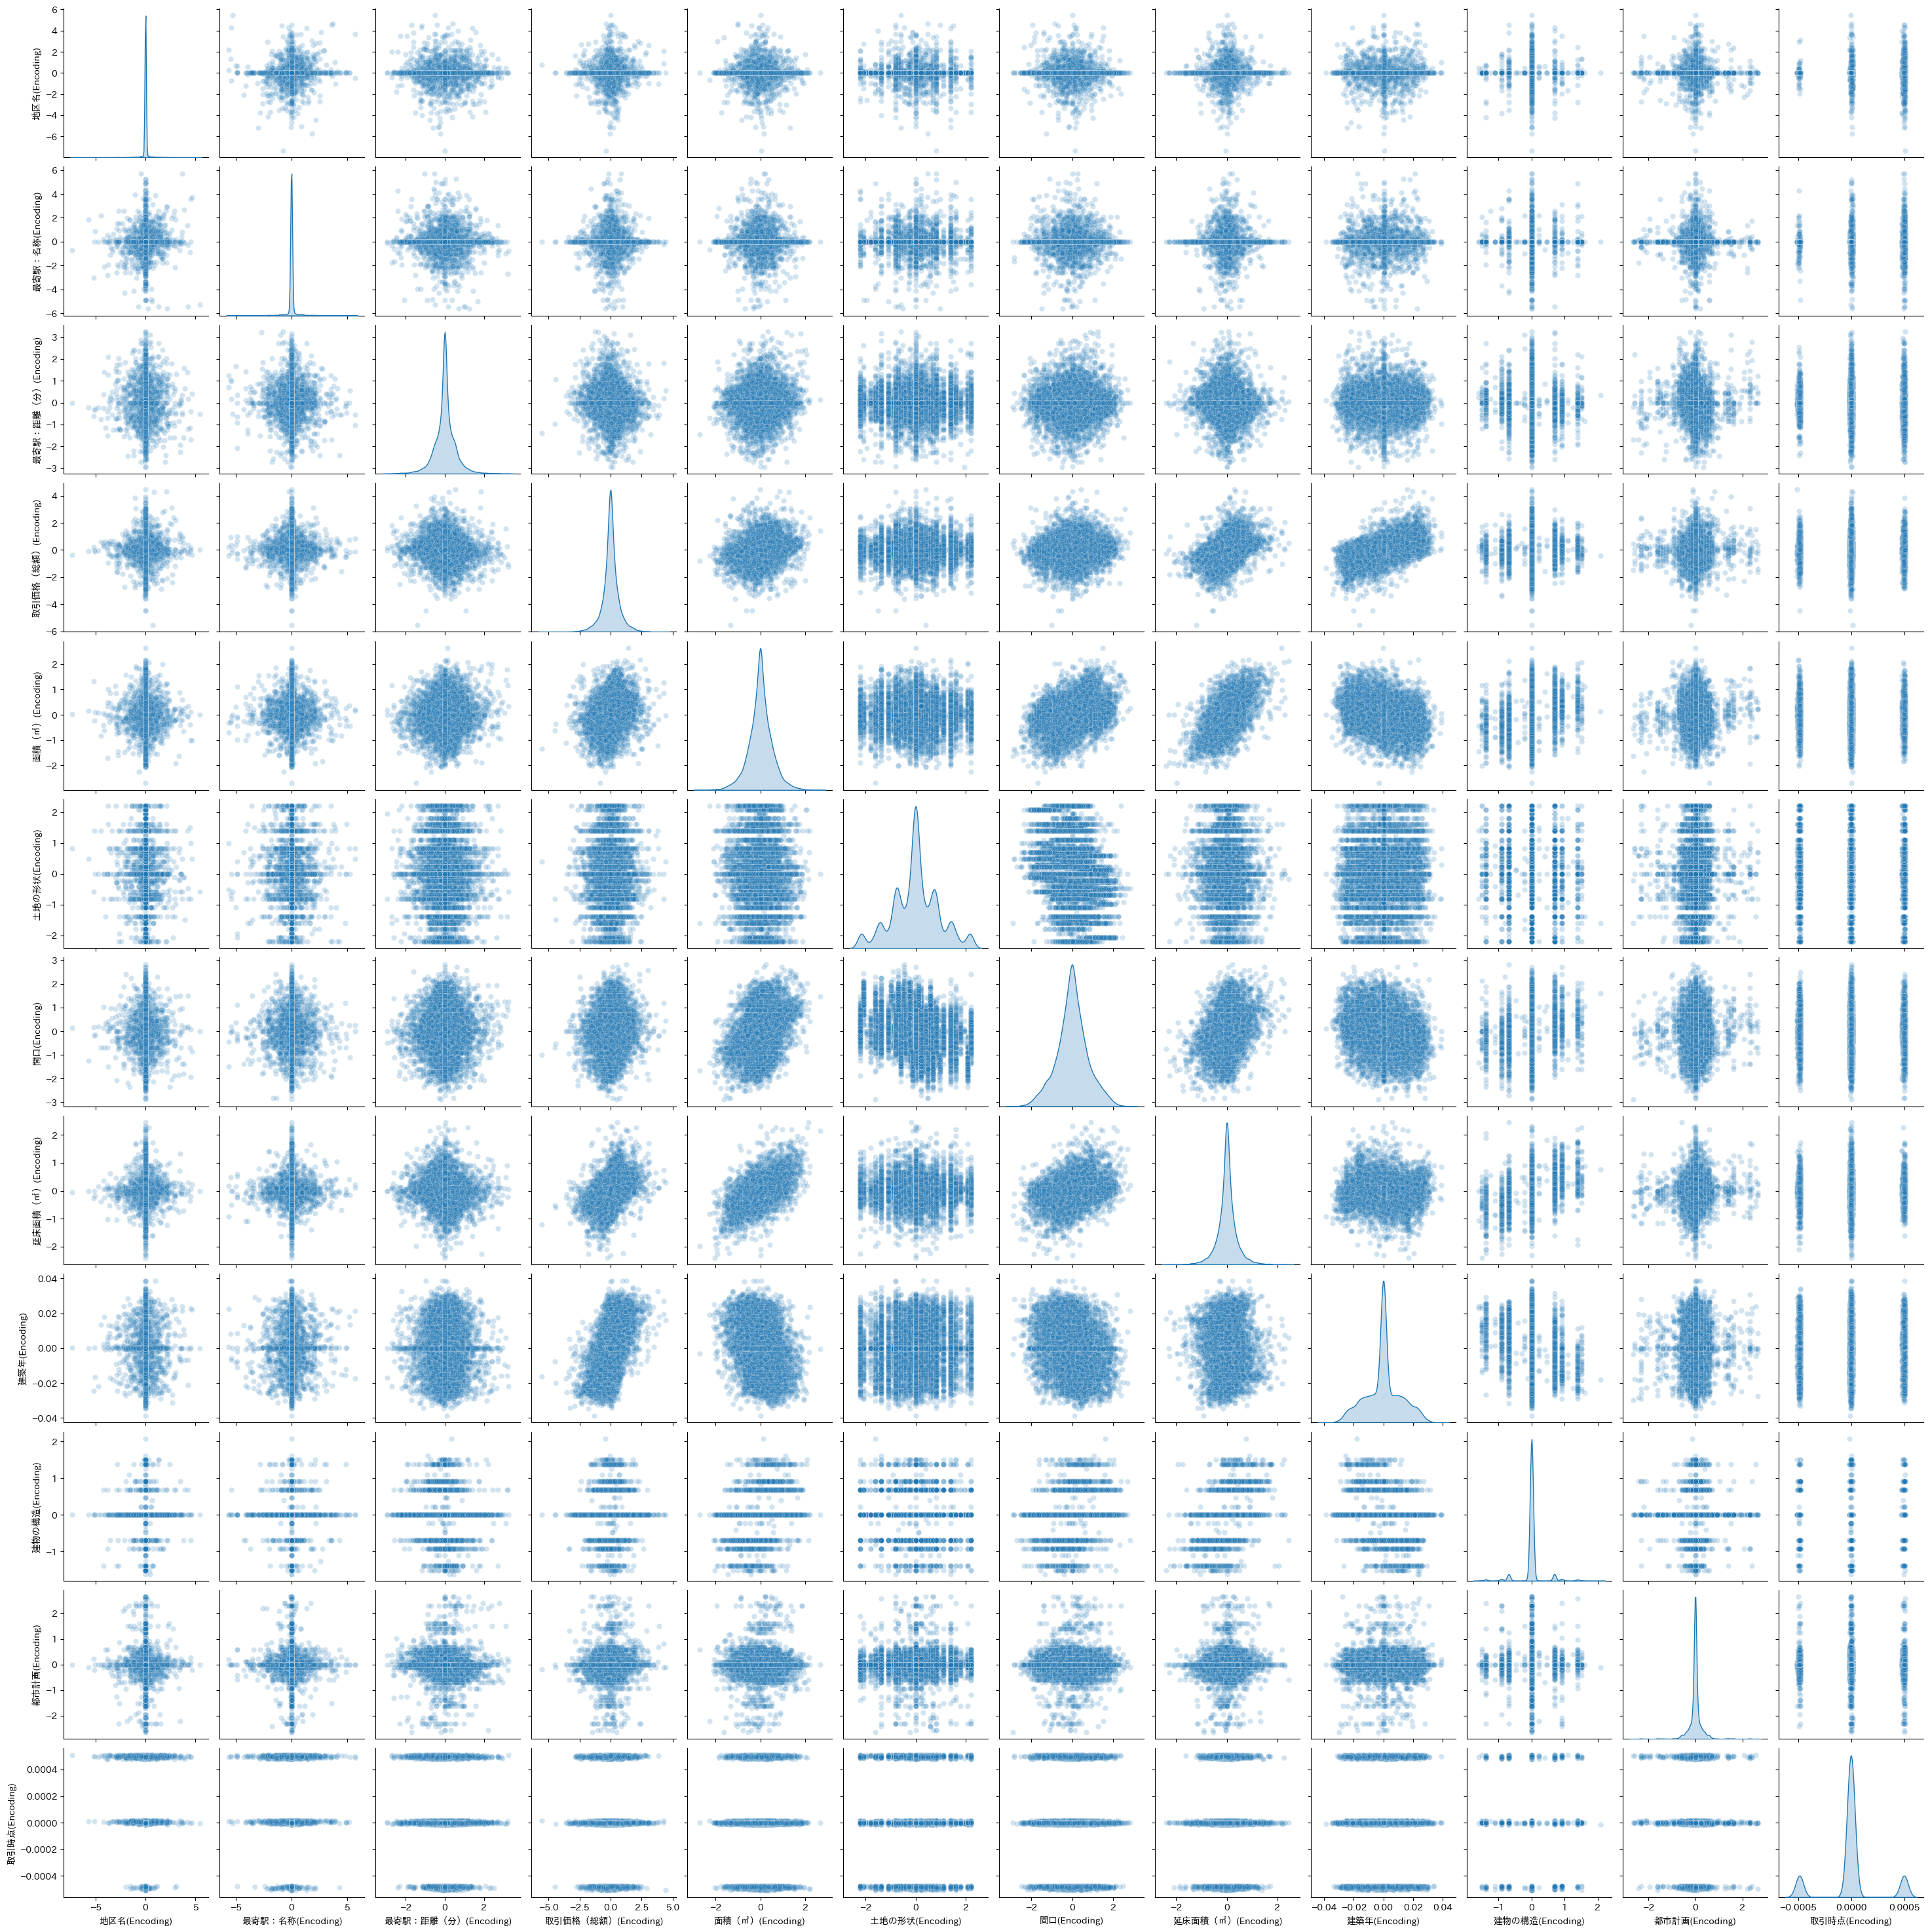

In [38]:
sns.pairplot(oh_trans_sns,diag_kind='kde',plot_kws={'alpha':0.2})

## ランダムフォレストによる特徴量の重要度を評価

 1) 最寄駅：名称(Encoding)               0.097319
 2) 最寄駅：距離（分）(Encoding)            0.088834
 3) 面積（㎡）(Encoding)                0.087833
 4) 取引価格（総額）(Encoding)             0.083077
 5) 地区名(Encoding)                  0.079949
 6) 間口(Encoding)                   0.079079
 7) 延床面積（㎡）(Encoding)              0.073125
 8) 建築年(Encoding)                  0.072197
 9) 前面道路：方位(Encoding)              0.070722
10) 取引時点(Encoding)                 0.069157
11) 前面道路：幅員（ｍ）(Encoding)           0.058825
12) 土地の形状(Encoding)                0.058515
13) 都市計画(Encoding)                 0.048081
14) 前面道路：種類(Encoding)              0.022963
15) 建物の構造(Encoding)                0.010323


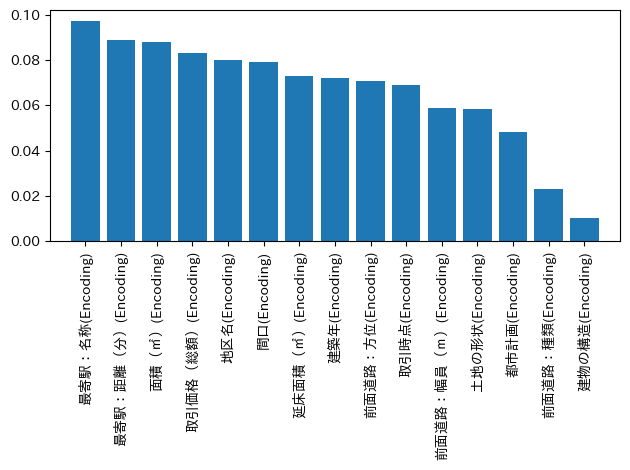

In [39]:
df_oh = df_oh.reindex(columns=["市区町村(Encoding)","地区名(Encoding)","最寄駅：名称(Encoding)",
                         "最寄駅：距離（分）(Encoding)","取引価格（総額）(Encoding)","面積（㎡）(Encoding)","土地の形状(Encoding)",
                         "間口(Encoding)","延床面積（㎡）(Encoding)","建築年(Encoding)","建物の構造(Encoding)",
                         "前面道路：方位(Encoding)","前面道路：種類(Encoding)","前面道路：幅員（ｍ）(Encoding)",
                         "都市計画(Encoding)","取引時点(Encoding)"])

# 目的変数(Y)、説明変数(X)
oh_Y = df_oh["取引価格（総額）(Encoding)"]
oh_X = df_oh[["市区町村(Encoding)","地区名(Encoding)","最寄駅：名称(Encoding)",
            "最寄駅：距離（分）(Encoding)","面積（㎡）(Encoding)","土地の形状(Encoding)",
            "間口(Encoding)","延床面積（㎡）(Encoding)","建築年(Encoding)","建物の構造(Encoding)",
            "前面道路：方位(Encoding)","前面道路：種類(Encoding)","前面道路：幅員（ｍ）(Encoding)",
            "都市計画(Encoding)","取引時点(Encoding)"]]

# データの分割
oh_X_train, oh_X_test, oh_Y_train, oh_Y_test = train_test_split(oh_X, oh_Y, test_size=0.3, random_state=2)

feat_labels = df_oh.columns[1:]

forest = RandomForestClassifier(n_estimators=500, random_state=1)

forest.fit(oh_X_train, oh_Y_train)

importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(oh_X_train.shape[1]):
  print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

plt.bar(range(oh_X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(oh_X_train.shape[1]), feat_labels[indices],rotation=90)
plt.xlim([-1, oh_X_train.shape[1]])
plt.tight_layout()
plt.show()

## 重回帰分析

In [40]:
#新しい特徴量の作成
df_oh["坪面積単価"] = df_oh["取引価格（総額）(Encoding)"] / df_oh["面積（㎡）(Encoding)"]
df_oh["容積率"] = df_oh["延床面積（㎡）(Encoding)"] / df_oh["面積（㎡）(Encoding)"]
df_oh["道路変数"] = df_oh["間口(Encoding)"] * df_oh["前面道路：幅員（ｍ）(Encoding)"] * df_oh["前面道路：方位(Encoding)"]


# 目的変数(Y)、説明変数(X)
oh_Y = df_oh["取引価格（総額）(Encoding)"]
oh_X = df_oh[["市区町村(Encoding)","地区名(Encoding)","最寄駅：名称(Encoding)",
            "最寄駅：距離（分）(Encoding)","面積（㎡）(Encoding)","土地の形状(Encoding)",
            "間口(Encoding)","建築年(Encoding)","延床面積（㎡）(Encoding)",
            "前面道路：方位(Encoding)","前面道路：幅員（ｍ）(Encoding)",
            "都市計画(Encoding)","取引時点(Encoding)","坪面積単価","容積率","道路変数"]]

# データの分割
oh_X_train, oh_X_test, oh_Y_train, oh_Y_test = train_test_split(oh_X, oh_Y, test_size=0.3, random_state=2)

#線形回帰モデル
oh_model = Ridge()

#学習はfit
oh_model.fit(oh_X_train, oh_Y_train)

#スコア予測
oh_model.score(oh_X_test,oh_Y_test)



0.787480720992638

## ハイパーパラメータチューニング

In [41]:
# ハイパーパラメータ探索空間の定義
param_space = {
    'alpha': (0.001, 10.0, 'log-uniform'),
    'fit_intercept': (True, False),
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'max_iter': (100, 10000)
}

# ベイズ最適化の設定
opt = BayesSearchCV(oh_model, param_space, n_iter=50, cv=5, n_jobs=-1)

# ベイズ最適化によるハイパーパラメータチューニング
opt.fit(oh_X_train, oh_Y_train)

# 最適なモデルのハイパーパラメータを表示
print("Best hyperparameters:", opt.best_params_)

# 最適なモデルの精度を表示
print("Best score:", opt.best_score_)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

Best hyperparameters: OrderedDict([('alpha', 10.0), ('fit_intercept', True), ('max_iter', 10000), ('solver', 'auto')])
Best score: 0.7814319255942241


# 中古マンション等

In [42]:
df_ap = df[df["種類"] == "中古マンション等"]

#いらないコラムを除く
df_ap = df_ap.drop({"土地の形状","間口","延床面積（㎡）","前面道路：方位","前面道路：種類","前面道路：幅員（ｍ）"},axis="columns")

#欠損データを除外
df_ap = df_ap.fillna({"間取り":"None"})
df_ap = df_ap[df_ap["間取り"] != "None"]

df_ap = df_ap.fillna({"改装":"None"})
df_ap = df_ap[df_ap["改装"] != "None"]

#エンコーディングを行う
df_ap["改装(Encoding)"] = LabelEncoder().fit_transform(df_ap["改装"].values) + 1
df_ap["間取り(Encoding)"] = LabelEncoder().fit_transform(df_ap["間取り"].values) + 1
df_ap["建物の構造(Encoding)"] = LabelEncoder().fit_transform(df_ap["建物の構造"].values) + 1

#データ型の変換
df_ap["No"] = df_ap["No"].astype(int)

df_ap["市区町村(Encoding)"] = df_ap["市区町村コード"].astype(int)

df_ap["取引価格（総額）(Encoding)"] = df_ap["取引価格（総額）"].astype(int)

df_ap["面積（㎡）(Encoding)"] = df_ap["面積（㎡）"].astype(int)

#データを絞る
df_ap = df_ap[df_ap["取引価格（総額）(Encoding)"] < 80000000]

df_ap = df_ap.reindex(columns=["No","種類(Encoding)","市区町村(Encoding)","地区名(Encoding)","最寄駅：名称(Encoding)",
                                "最寄駅：距離（分）(Encoding)","取引価格（総額）(Encoding)","間取り(Encoding)","面積（㎡）(Encoding)",
                                "建築年(Encoding)","建物の構造(Encoding)","都市計画(Encoding)","取引時点(Encoding)"])

In [43]:
df_ap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9394 entries, 2 to 39117
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   No                   9394 non-null   int64
 1   種類(Encoding)         9394 non-null   int64
 2   市区町村(Encoding)       9394 non-null   int64
 3   地区名(Encoding)        9394 non-null   int64
 4   最寄駅：名称(Encoding)     9394 non-null   int64
 5   最寄駅：距離（分）(Encoding)  9394 non-null   int64
 6   取引価格（総額）(Encoding)   9394 non-null   int64
 7   間取り(Encoding)        9394 non-null   int64
 8   面積（㎡）(Encoding)      9394 non-null   int64
 9   建築年(Encoding)        9394 non-null   int64
 10  建物の構造(Encoding)      9394 non-null   int64
 11  都市計画(Encoding)       9394 non-null   int64
 12  取引時点(Encoding)       9394 non-null   int64
dtypes: int64(13)
memory usage: 1.0 MB


### 可視化

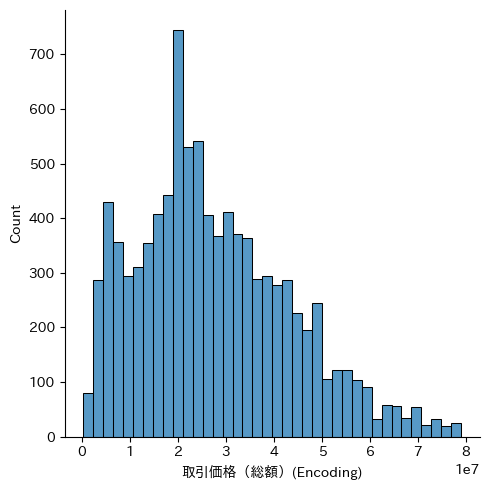

In [44]:
sns.displot(df_ap["取引価格（総額）(Encoding)"])

In [45]:
ap_sns = df_ap[["取引価格（総額）(Encoding)","地区名(Encoding)","最寄駅：名称(Encoding)","最寄駅：距離（分）(Encoding)",
                "間取り(Encoding)","面積（㎡）(Encoding)","取引時点(Encoding)","建築年(Encoding)","建物の構造(Encoding)",
                "都市計画(Encoding)"]]
ap_trans_sns = np.log(ap_sns).diff().dropna()

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


<Axes: xlabel='取引価格（総額）(Encoding)', ylabel='面積（㎡）(Encoding)'>

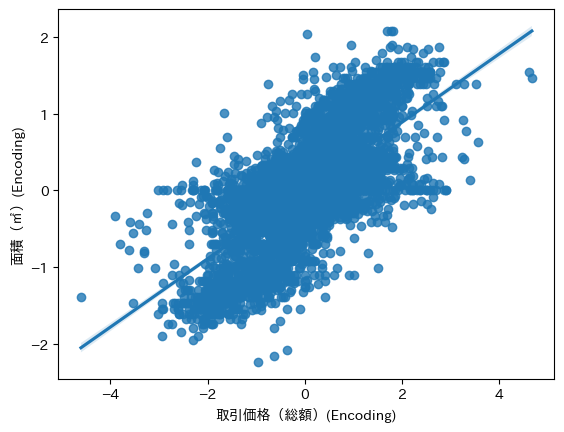

In [46]:
sns.regplot(x="取引価格（総額）(Encoding)",y="面積（㎡）(Encoding)",data=ap_trans_sns)

<Axes: xlabel='取引価格（総額）(Encoding)', ylabel='最寄駅：名称(Encoding)'>

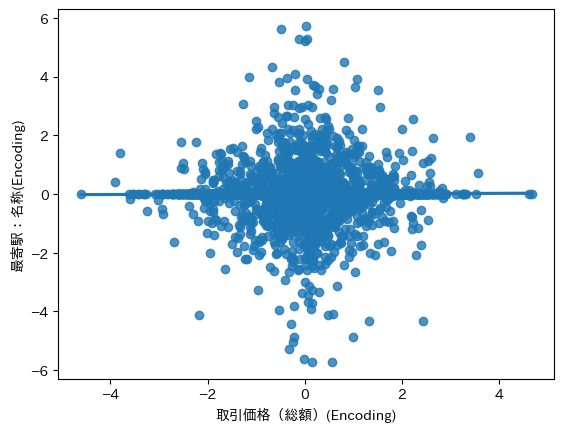

In [47]:
sns.regplot(x="取引価格（総額）(Encoding)",y="最寄駅：名称(Encoding)",data=ap_trans_sns)

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


<Axes: xlabel='取引価格（総額）(Encoding)', ylabel='最寄駅：距離（分）(Encoding)'>

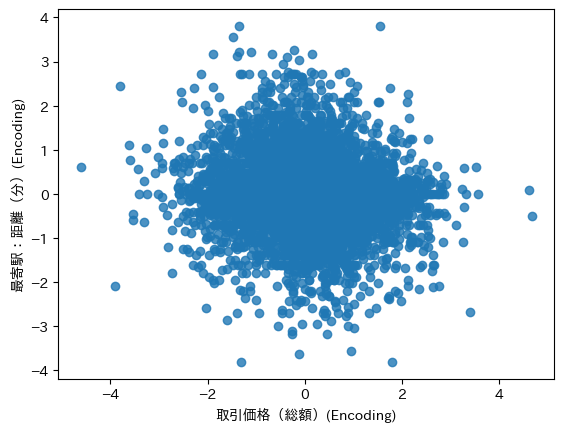

In [48]:
sns.regplot(x="取引価格（総額）(Encoding)",y="最寄駅：距離（分）(Encoding)",data=ap_trans_sns)

<Axes: xlabel='取引価格（総額）(Encoding)', ylabel='取引時点(Encoding)'>

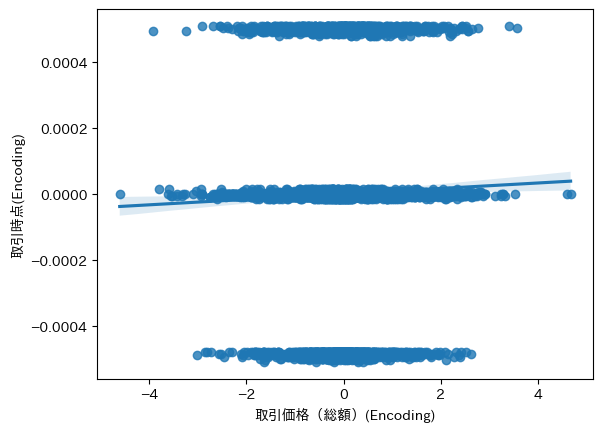

In [49]:
sns.regplot(x="取引価格（総額）(Encoding)",y="取引時点(Encoding)",data=ap_trans_sns)

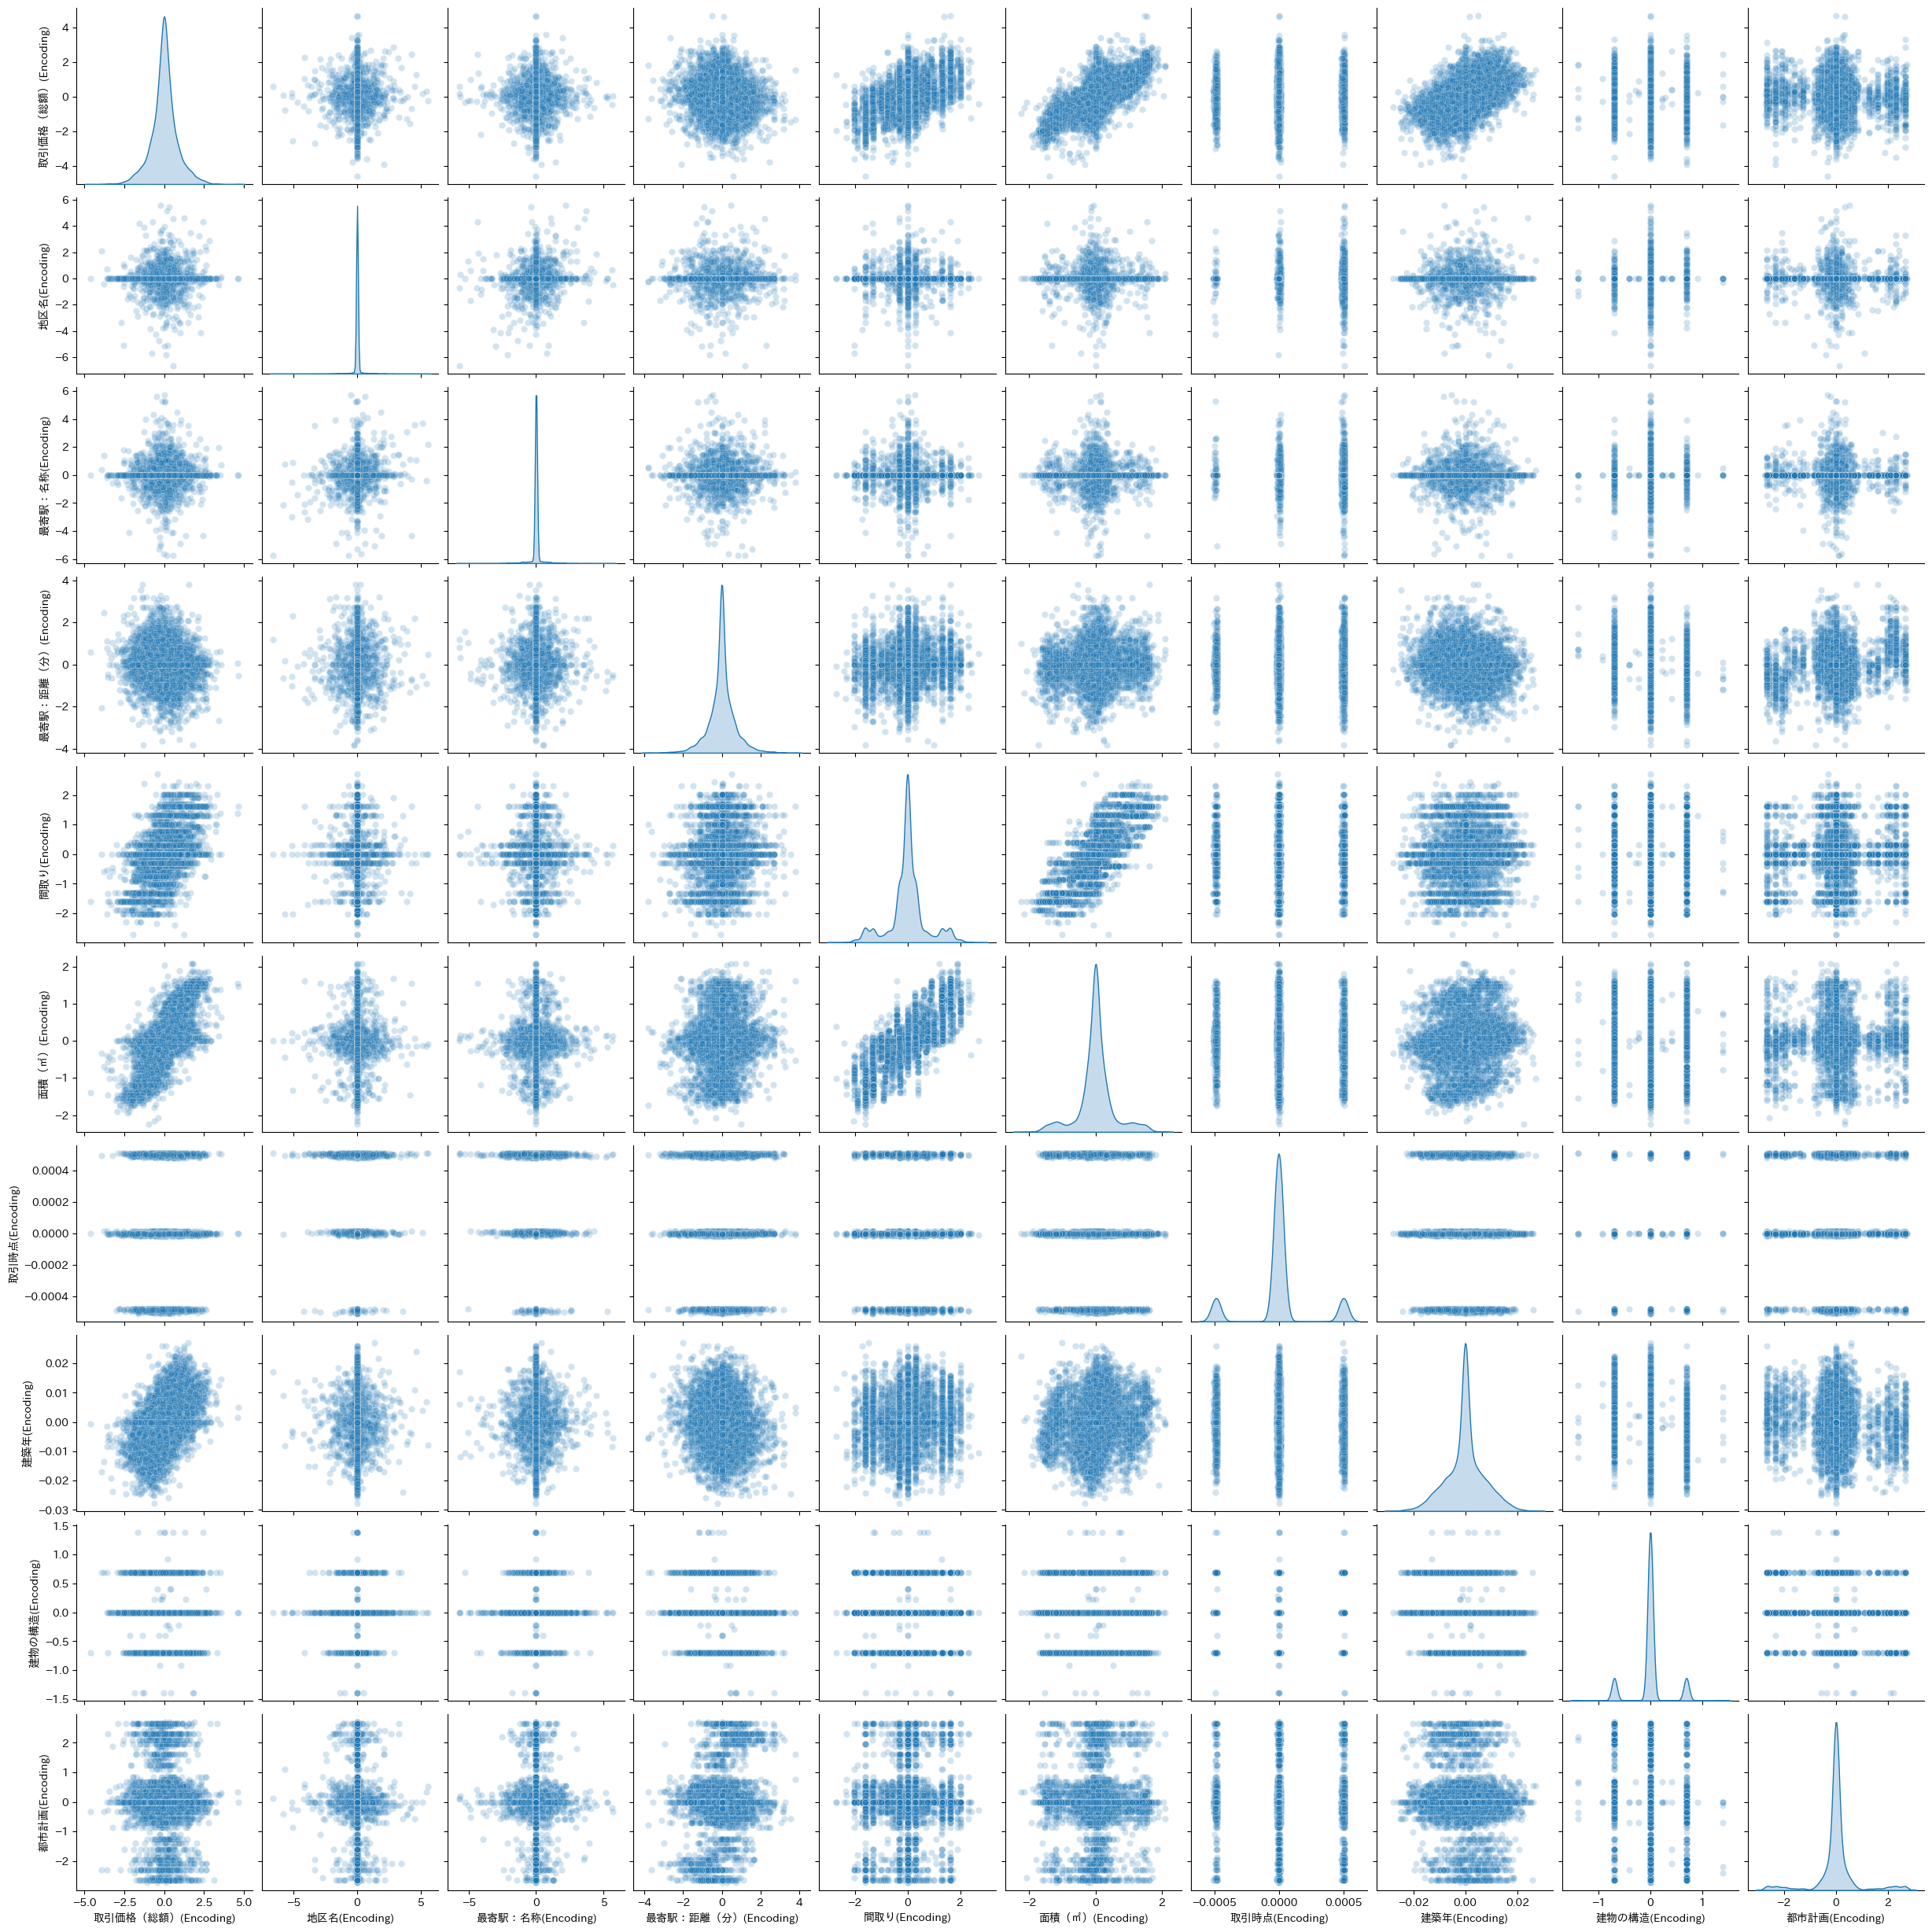

In [50]:
sns.pairplot(ap_trans_sns,diag_kind='kde',plot_kws={'alpha':0.2})

## ランダムフォレストによる特徴量の重要度を評価

 1) 取引時点(Encoding)                 0.145631
 2) 建築年(Encoding)                  0.130637
 3) 最寄駅：名称(Encoding)               0.128890
 4) 取引価格（総額）(Encoding)             0.122807
 5) 最寄駅：距離（分）(Encoding)            0.118615
 6) 地区名(Encoding)                  0.101270
 7) 面積（㎡）(Encoding)                0.099102
 8) 都市計画(Encoding)                 0.072850
 9) 間取り(Encoding)                  0.058723
10) 建物の構造(Encoding)                0.021475


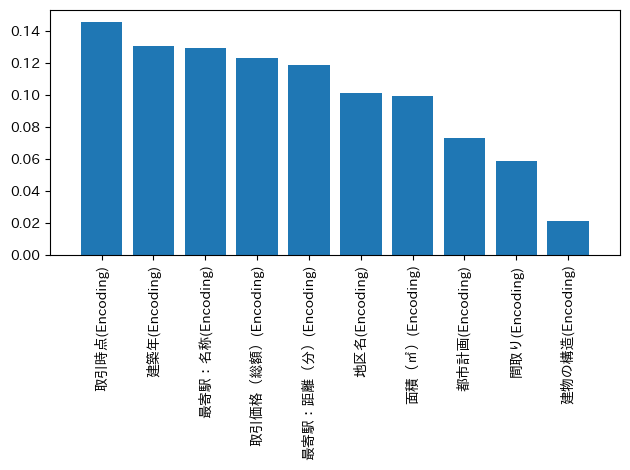

In [51]:
df_ap = df_ap.reindex(columns=["市区町村(Encoding)","地区名(Encoding)","最寄駅：名称(Encoding)",
                                "最寄駅：距離（分）(Encoding)","取引価格（総額）(Encoding)","間取り(Encoding)","面積（㎡）(Encoding)",
                                "建築年(Encoding)","建物の構造(Encoding)","都市計画(Encoding)","取引時点(Encoding)"])

# 目的変数(Y)、説明変数(X)
ap_Y = df_ap["取引価格（総額）(Encoding)"]
ap_X = df_ap[["市区町村(Encoding)","地区名(Encoding)","最寄駅：名称(Encoding)",
            "最寄駅：距離（分）(Encoding)","間取り(Encoding)","面積（㎡）(Encoding)",
            "建築年(Encoding)","建物の構造(Encoding)","都市計画(Encoding)","取引時点(Encoding)"]]

# データの分割
ap_X_train, ap_X_test, ap_Y_train, ap_Y_test = train_test_split(ap_X, ap_Y, test_size=0.3, random_state=3)

feat_labels = df_ap.columns[1::]

forest = RandomForestClassifier(n_estimators=500, random_state=1)

forest.fit(ap_X_train, ap_Y_train)

importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(ap_X_train.shape[1]):
  print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

plt.bar(range(ap_X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(ap_X_train.shape[1]), feat_labels[indices],rotation=90)
plt.xlim([-1, ap_X_train.shape[1]])
plt.tight_layout()
plt.show()

## 重回帰分析

In [52]:
# 目的変数(Y)、説明変数(X)
ap_Y = df_ap["取引価格（総額）(Encoding)"]
ap_X = df_ap[["市区町村(Encoding)","地区名(Encoding)","最寄駅：名称(Encoding)",
            "最寄駅：距離（分）(Encoding)","間取り(Encoding)","面積（㎡）(Encoding)",
            "建築年(Encoding)","都市計画(Encoding)","取引時点(Encoding)"]]

# データの分割
ap_X_train, ap_X_test, ap_Y_train, ap_Y_test = train_test_split(ap_X, ap_Y, test_size=0.3, random_state=1)

#線形回帰モデル
ap_model = Ridge()

#学習はfit
ap_model.fit(ap_X_train, ap_Y_train)

#スコア予測
ap_model.score(ap_X_test,ap_Y_test)

0.6306499941144903

## ハイパーパラメータチューニング

In [53]:
# ハイパーパラメータ探索空間の定義
param_space = {
    'alpha': (0.001, 10.0, 'log-uniform'),
    'fit_intercept': (True, False),
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'max_iter': (100, 10000)
}

# ベイズ最適化の設定
opt = BayesSearchCV(ap_model, param_space, n_iter=50, cv=5, n_jobs=-1)

# ベイズ最適化によるハイパーパラメータチューニング
opt.fit(ap_X_train, ap_Y_train)

# 最適なモデルのハイパーパラメータを表示
print("Best hyperparameters:", opt.best_params_)

# 最適なモデルの精度を表示
print("Best score:", opt.best_score_)

Best hyperparameters: OrderedDict([('alpha', 0.10414272373633884), ('fit_intercept', True), ('max_iter', 3570), ('solver', 'sag')])
Best score: 0.6201545802080056
